In [1]:
using DrWatson
@quickactivate :NARMAXExperiments

In [2]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using FFTW
using Parameters
import ProgressMeter
using CSV
using DataFrames
using MAT
gr()

Plots.GRBackend()

In [3]:
import ReactiveMP.messageout

## Load generated signal

In [4]:
# Pick the seed from 1 to 100
seed = 69

69

In [187]:
# load results of ILS filter for simulation and predictions
mat_ils = matread("../datasets/verification/ils_results/results-NARMAX_ILS_stde0.05_pol3_delays4_D22_degree3_r$(seed).mat")


Dict{String, Any} with 2 entries:
  "RMS_sim" => [NaN 0.0577726 0.0519446 0.0504042]
  "RMS_prd" => [NaN NaN 0.0516473 0.0499913]

In [188]:


# Load from .mat file
mat_data = matread("../datasets/verification/realizations/NARMAXsignal_stde0.05_degree3_delays4_D22_r$(seed).mat")

train_size = 1000
test_size = 1000

# Length of transient period
transient = 0

# Length of training signal
ix_trn = collect(1:train_size) .+ transient

# Length of testing signal
ix_tst = collect(1:test_size) .+ transient;

# Extract data sets
input_trn = mat_data["uTrain"][ix_trn]
noise_trn = mat_data["eTrain"][ix_trn]
output_trn = mat_data["yTrain"][ix_trn]
T_trn = length(input_trn)

input_tst = mat_data["uTest"][ix_tst]
noise_tst = mat_data["eTest"][ix_tst]
output_tst = mat_data["yTest"][ix_tst]
T_tst = length(input_tst)

# System parameters
η_true = mat_data["system"]["theta"][:]
τ_true = inv(mat_data["options"]["stde"]^2);

In [5]:
df = DataFrame(CSV.File("../datasets/dataBenchmark.csv"));
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]

([3.2567, 3.2466, 3.2309, 3.2097, 3.1836, 3.1531, 3.1194, 3.084, 3.0485, 3.0148  …  3.0784, 3.1195, 3.155, 3.1851, 3.21, 3.23, 3.2451, 3.2554, 3.261, 3.2615], [0.97619, 0.99921, 1.0172, 1.0318, 1.0456, 1.0624, 1.0861, 1.121, 1.1704, 1.2371  …  1.0186, 0.92978, 0.86944, 0.83561, 0.82488, 0.83275, 0.85406, 0.88351, 0.9162, 0.94805], [5.205, 5.2154, 5.2215, 5.2142, 5.2001, 5.2309, 5.2163, 5.2081, 5.2041, 5.2178  …  3.6101, 3.6245, 3.6312, 3.6144, 3.6553, 3.6672, 3.6379, 3.6883, 3.6831, 3.6831], [4.9728, 4.9722, 4.9703, 4.988, 4.9825, 4.9685, 4.9706, 4.9355, 4.9041, 4.815  …  3.8296, 3.8259, 3.7963, 3.8198, 3.8177, 3.7881, 3.7978, 3.7807, 3.7151, 3.7179])

In [6]:
# normalization
output_trn = y_train
output_val = y_val
input_trn = u_train
input_val = u_val

output_trn = y_train
output_val = y_val
input_trn = input_trn
input_val = input_val

output_trn = collect(Iterators.flatten([output_trn[1:10:end] for i in 1:10]))
output_val = collect(Iterators.flatten([output_val[1:10:end] for i in 1:10]))
input_trn = collect(Iterators.flatten([input_trn[1:10:end] for i in 1:10]))
input_val = collect(Iterators.flatten([input_val[1:10:end] for i in 1:10]))


output_trn = collect(Iterators.flatten([output_trn[1:1:end] for i in 1:3]))
output_val = collect(Iterators.flatten([output_val[1:1:end] for i in 1:3]))
input_trn = collect(Iterators.flatten([input_trn[1:1:end] for i in 1:3]))
input_val = collect(Iterators.flatten([input_val[1:1:end] for i in 1:3]));

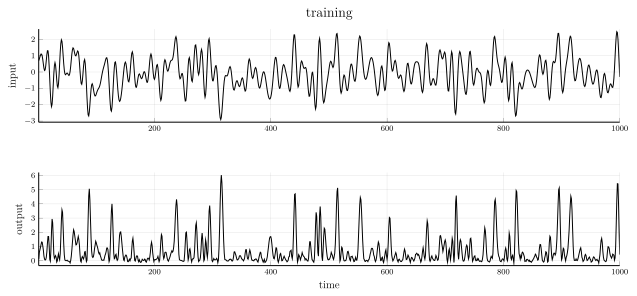

In [189]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1), xlims=(1, train_size))

### prepare training/test sets 

In [116]:
delay_y, delay_u, delay_e = 2, 2, 1 #Int.(ones(3))
order_u = delay_u + 1
poly_order = 4;

In [117]:
train_size = 1000
test_size = 1000
# train_size = 100
# test_size = 50

# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, delay_u+1)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, delay_u+1)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [118]:
# # Generate training data
# observations_prev, observations = ssm(output_trn, delay_y)
# controls = ssm(input_trn, order_u)[1]
# X_train, Y_train, U_train = observations_prev[1:train_size-order_u], observations[1:train_size-order_u], controls[1:train_size-order_u];

# # Generate validation data
# observations_prev, observations = ssm(output_tst, delay_y)
# controls = ssm(input_tst, order_u)[1]
# X_test, Y_test, U_test = observations_prev[1:test_size-order_u], observations[1:test_size-order_u], controls[1:test_size-order_u];

In [119]:
# Unfortunately the redefinition of phi will require Julia kernel restart 
# FIXME

function phi()
    options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)
    
    precompiled = precompiled_phi(options)
    
    return (u, y, h) -> begin
        na = length(y)
        nb = length(u)-1
        ne = length(h)-1
        precompiled([u; y; h[1:end]])
    end 
end

const phi4_ = phi()

#133 (generic function with 1 method)

In [120]:
options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)

full_order = length(ϕ(zeros(delay_y+delay_e+order_u), options))

println("NARMAX order is $(full_order)")

NARMAX order is 129


In [121]:
# Nonlinear MAX model definition
@model function narmax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, delay_e, order)
        
    S = shift(delay_e); c = zeros(delay_e); c[1] = 1.0;
    
    # initialize variables
    w  = randomvar()
    h  = randomvar(n-1)
    e  = randomvar(n)
    z  = randomvar(n)
    ẑ  = randomvar(n)
    y  = datavar(Float64, n)
        
    # priors
    w  ~ GammaShapeRate(w_prior[1], w_prior[2])
    η  ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ  ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    # initial
    h_0  ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    z[1] ~ NonlinearNode(h_0) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))), meta = NonlinearMeta(UT(), phi4_, y_prev[1], u[1])}
    ẑ[1] ~ AR(z[1], η, τ)
    
    b = zeros(order); b[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n-1
        
        e[t] ~ NormalMeanPrecision(0.0, w)
        h[t] ~ S*h_prev + c*e[t]
        y[t] ~ dot(ẑ[t], b) + e[t]
    
        h_prev = h[t]
        z[t+1] ~ NonlinearNode(h_prev) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))), meta = NonlinearMeta(UT(), phi4_, y_prev[t+1], u[t+1])}
        ẑ[t+1] ~ AR(z[t+1], η, τ)
    end
    
    e[n] ~ NormalMeanPrecision(0.0, w)
    y[n] ~ dot(ẑ[n], b) + e[n]

    return w, h, η, τ, z, ẑ, y
end

In [122]:
# Create priors

coefs_mean = zeros(full_order);
coefs_precision = diageye(full_order);

w_prior, τ_prior =  GammaShapeRate(1.0, 1.0), GammaShapeRate(1e2, 1.0)
h_prior, η_prior = MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e)),  MvNormalMeanPrecision(coefs_mean, coefs_precision)

(MvNormalMeanPrecision(
μ: [0.0]
Λ: [1.0;;]
)
, MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Λ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)
)

In [123]:
narmax_imarginals = (h = h_prior,
                     w = w_prior,
                     τ = τ_prior,
                     η = η_prior);

In [124]:
narmax_imessages = (e = NormalMeanPrecision(0.0, var(Y_train)), );

In [125]:
@meta function narmax_meta(artype, order, stype)
    AR(ẑ, η, τ) -> ARMeta(artype, order, stype)
end

narmax_meta (generic function with 1 method)

In [126]:
narmax_constraints = @constraints begin
    q(ẑ, z, η, τ, e, w, h, h_0) = q(ẑ, z, h, h_0)q(η)q(τ)q(e)q(w)
end;

In [127]:
narmax_model = Model(narmax, length(Y_train[1:100]), 
                    (mean(h_prior), precision(h_prior)), 
                    (shape(w_prior), rate(w_prior)), 
                    (mean(η_prior), precision(η_prior)), 
                    (shape(τ_prior), rate(τ_prior)), 
                    X_train, U_train, delay_e, full_order);

In [128]:
# First execution is slow due to Julia's init compilation 
result = inference(
    model = narmax_model, 
    data  = (y = Y_train[1:100], ),
    constraints   = narmax_constraints,
    meta          = narmax_meta(Multivariate, full_order, ARsafe()),
    options       = model_options(limit_stack_depth = 500),
    initmarginals = narmax_imarginals,
    initmessages  = narmax_imessages,
    returnvars    = (w=KeepLast(), h=KeepLast(), e=KeepLast(), η=KeepEach(), τ=KeepLast(), z=KeepLast(), ẑ=KeepLast()),
    free_energy   = true,
    iterations    = 50, 
    showprogress  = true
);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:04


In [129]:
fe = result.free_energy

50-element Vector{Real}:
 1522.4066819429208
 2394.0604498337125
 2755.759283604595
 2338.9362426796724
 2025.9084766005617
 1748.770340311181
 1705.7774156538253
 1595.1136525708644
 1551.9708632942202
 1478.9658720809894
 1440.859052560645
 1414.609262767517
 1360.9964978318094
    ⋮
 1003.8290564886101
  985.245740553912
  963.7155473394248
  941.462116462438
  945.9531215397799
  910.3431380700763
  902.6993048815111
  899.5938190776501
  910.2648941817524
  900.9200126761862
  902.0448129246452
  915.8183502121276

In [130]:
using Parameters
@unpack w, h, η, τ, z, ẑ, e = result.posteriors

Dict{Symbol, Any} with 7 entries:
  :w => Marginal(GammaShapeRate{Float64}(a=51.0, b=6.7218186104741715))
  :ẑ => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :e => Marginal[Marginal(NormalWeightedMeanPrecision{Float64}(xi=-0.0984028858…
  :τ => Marginal(GammaShapeRate{Float64}(a=150.0, b=148.8339884584389))
  :h => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :z => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :η => Marginal[Marginal(MvNormalWeightedMeanPrecision(…

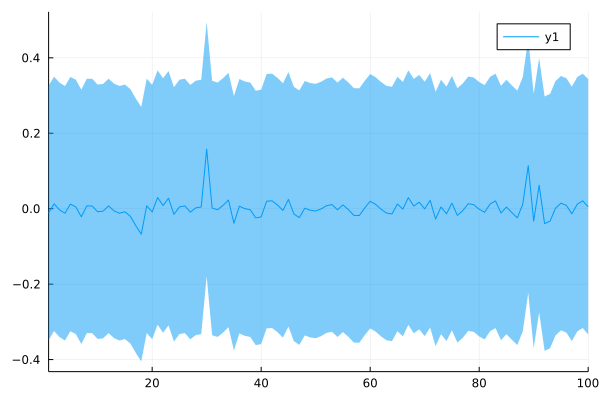

In [131]:
gr()
# plot(noise_trn[2:end])
plot(first.(mean.(e)), ribbon=sqrt.(first.(cov.(e))), xlims=(1, 100))

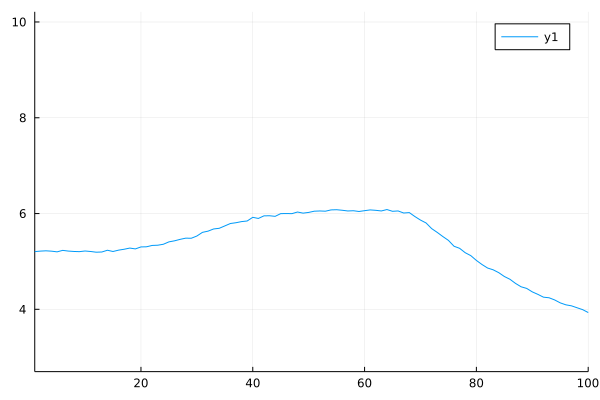

In [132]:
plot(y_train, xlims=(1, 100))

In [133]:
using DataStructures

threshold = 0.02
good_η_dict = SortedDict(η_true[findall(e -> abs(e) > threshold, η_true)] .=> findall(e -> abs(e) > threshold, η_true))

LoadError: UndefVarError: η_true not defined

In [134]:
using LaTeXStrings
pgfplotsx()

real_θ = good_η_dict

pgfplotsx()
pθ = plot()
θms = mean.(η)
θvs = var.(η)

l = length(θms)

nums = (7, 4)

edim(e) = (a) -> map(r -> r[e], a)
colors_ = Dict(nums[1]=>"red", nums[2]=>"blue")
for (val, key) in zip(values(real_θ), keys(real_θ))
    if val == nums[1] || val == nums[2]
        plot!(pθ, θms |> edim(val), ribbon = θvs |> edim(val) .|> sqrt, linestyle=:dash, linewidth=2.0, label=L"\theta_{%$val}={%$(round(key, digits=3))}", fillalpha=0.3, color=colors_[val])
    end
end

for (val, key) in zip(values(real_θ), keys(real_θ))
    if val == nums[1] || val == nums[2]
        plot!(pθ, [ key ], seriestype = :hline, linewidth=1.5, label=false, color=colors_[val])
    end
end

plot!(size = (400, 400), legend=:bottomright, ylabel="value", xlabel="iteration",  ylabelfontsize=13, xlabelfontsize=13, legendfontsize=10, markeralpha=0.4, xtickfontsize=10, ytickfontsize=10, xticks=0:5:20, xlims=(1, 20))
savefig(pθ, "../experiments/results/synthetic/inference_theta.tikz")



LoadError: UndefVarError: good_η_dict not defined

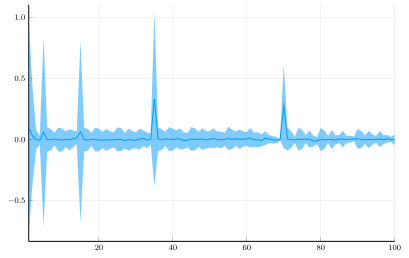

In [135]:
plot(mean(η[end]), ribbon=diag(std(η[end])), label=false, xlims=(1, 100))
# plot!(η_true, label=false) 

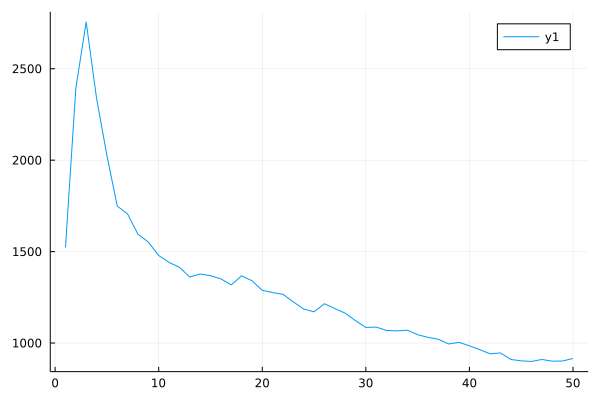

In [136]:
gr()
plot(fe[1:end])

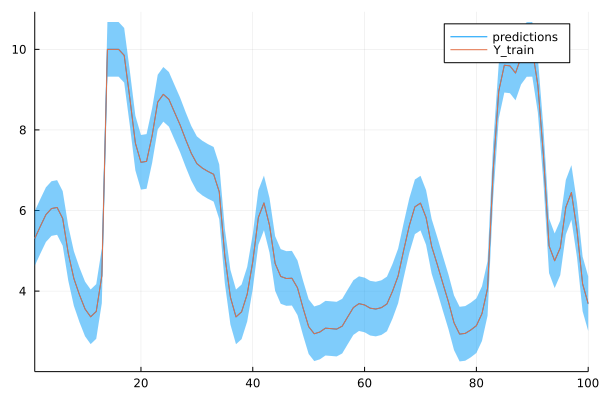

In [137]:
mfrom, mto = 1, 100
plot(first.(mean.(ẑ)) + mean.(e), ribbon=first.(sqrt.(cov.(ẑ))) + sqrt.(var.(e)), label="predictions")
plot!(Y_train, xlims=(mfrom, mto), label="Y_train")

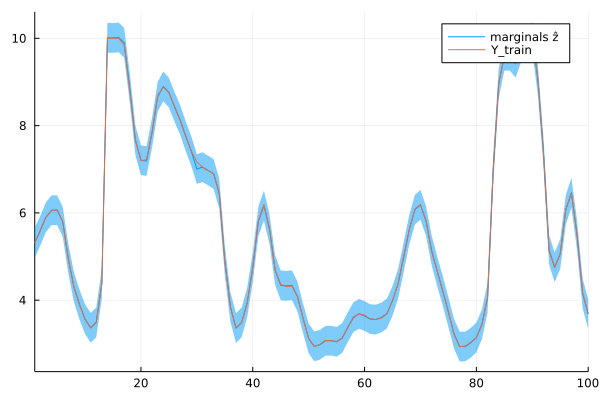

In [138]:
mfrom, mto = 1, 100
plot(first.(mean.(ẑ)), ribbon=first.(sqrt.(cov.(ẑ))), label="marginals ẑ")
plot!(Y_train, xlims=(mfrom, mto), label="Y_train")

In [139]:
mean(w)

7.587232407689495

In [140]:
mean(τ)

1.0078343095796745

## Prediction 

In [141]:
import NARMAXExperiments.prediction

function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order)
    h_out = MvNormalMeanPrecision(mean(h_prior), precision(h_prior))
    ϕ_out = @call_rule NonlinearNode(:out, Marginalisation) (m_in=h_out, meta=NonlinearMeta(UT(), phi4_, y_prev, u))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=ϕ_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    e_out = @call_rule NormalMeanPrecision(:out, Marginalisation) (m_μ=PointMass(0.0), m_τ=PointMass(w_mle))
    
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=e_out)  
end

prediction (generic function with 2 methods)

In [142]:
# Nonlinear MAX model definition
@model function narmax_mini(h_prior, w_prior, η_prior, τ_prior, y_prev, u, delay_e, order)
        
    S = shift(delay_e); c = zeros(delay_e); c[1] = 1.0;
    h = randomvar()
    # initialize variables
    y  = datavar(Float64)
    # priors
    w  ~ GammaShapeRate(shape(w_prior), rate(w_prior))
    η  ~ MvNormalMeanPrecision(mean(η_prior), precision(η_prior))
    τ  ~ GammaShapeRate(shape(τ_prior), rate(τ_prior))
    # initial
    h_0  ~ MvNormalMeanPrecision(mean(h_prior), precision(h_prior))
    z ~ NonlinearNode(h_0) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))), meta = NonlinearMeta(UT(), phi4_, y_prev, u)}
    ẑ ~ AR(z, η, τ)
    e ~ NormalMeanPrecision(0.0, w)
    b = zeros(order); b[1] = 1.0;
    y ~ dot(b, ẑ) + e
    h ~ S*h_0 + c*e
    h ~ MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))

    return
end

In [143]:
import NARMAXExperiments.inference_callback

function inference_callback(h_prior, η_prior, τ_prior, w_prior, Y, X, U, delay_e, order)
    
    narmax_mini_model = Model(narmax_mini, h_prior, w_prior, η_prior, τ_prior, X, U, delay_e, full_order)

    mini_constraints = @constraints begin
        q(ẑ, z, η, τ, e, w, h_0, h) = q(ẑ, z, h_0, h)q(η)q(τ)q(e)q(w)
    end;

    mini_imarginals = (h_0 = h_prior,
                       w = w_prior,
                       τ = τ_prior,
                       η = η_prior);

    mini_imessages = (e = NormalMeanPrecision(0.0, 1.0), );
    
    mini_result = inference(
                    model = narmax_mini_model, 
                    data  = (y = Y, ),
                    constraints   = mini_constraints,
                    meta          = narmax_meta(Multivariate, full_order, ARsafe()),
                    initmarginals = mini_imarginals, 
                    initmessages  = mini_imessages,
                    returnvars    = (w=KeepLast(), e=KeepLast(), η=KeepLast(), τ=KeepLast(), z=KeepLast(), ẑ=KeepLast(), h_0=KeepLast(), h=KeepLast()),
                    free_energy   = true,
                    iterations    = 20, 
                    showprogress  = true
                );
    @unpack w, e, η, τ, z, ẑ, h_0, h = mini_result.posteriors
    w.data, e.data, η.data, τ.data, h.data
end

inference_callback (generic function with 2 methods)

In [ ]:
predictions = []
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η[end].data

errors = []
ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_prior), η_prior, τ_prior, full_order=full_order, meta = NonlinearMeta(UT(), phi4_, X_test[i], U_test[i],))
    push!(predictions, pred)
#     w_post, e_post, η_post, τ_post, h_post  = inference_callback(h_prior, η_prior, τ_prior, w_prior, Y_test[i], X_test[i], U_test[i], delay_e, full_order)
#     h_prior = h_post
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
#     push!(errors, e_post)
end

Progress:  56%|███████████████████████▏                 |  ETA: 0:00:02

In [97]:
gr()
# plot(noise_tst[end-length(errors)-1:end])
# plot(mean.(errors), ribbon=sqrt.(cov.(errors)), xlims=(1, 100))

Plots.GRBackend()

In [98]:
errors;

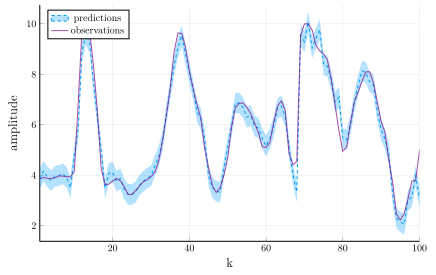

In [99]:
pgfplotsx()

pp = plot(mean.(predictions), ribbon=sqrt.(first.(var.(predictions))), fillalpha=0.3, linestyle=:dash, label="predictions", legend=:topleft, xlabel="k", ylabel="amplitude", )
plot!(Y_test, xlims=(1, 100), label="observations", ylabelfontsize=13, xlabelfontsize=13, legendfontsize=10, markeralpha=0.3, xtickfontsize=10, ytickfontsize=10, color=:purple, width=1.0, alpha=0.7)
# savefig(pp, "../experiments/results/synthetic/predictions.tikz")

In [59]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.43492841212241934

In [55]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.3760883788718237

In [100]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.4203846121281417

# Simulation

In [101]:
h_prior = MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))#h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η[end].data

simulated_X = [X_test[1]]
simulated_Y = [NormalMeanPrecision(Y_test[1], 1e4) for _ in 1:delay_y]
simulated_error = Vector{Any}([h_prior])

ProgressMeter.@showprogress for i in 1:length(Y_test)
    
    push!(simulated_X, [mean(simulated_Y[i]); simulated_X[i][1:delay_y-1]])
    msg_y = MvNormalMeanPrecision(mean.(simulated_Y[end-delay_y+1:end]), Diagonal(var.(simulated_Y[end-delay_y+1:end])))
    pred_sim = prediction_(h_prior, msg_y, mean(w_prior), η_prior, τ_prior, full_order=full_order, meta=NonlinearMeta(UT(), phi4_, X_test[i], U_test[i]))
    push!(simulated_Y, pred_sim)
    push!(simulated_error, h_prior)
    

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


In [58]:
RMSE = sqrt(mean((mean.(simulated_Y[delay_y+1:end]) .- Y_test).^2))

1.4098723946127167

In [102]:
RMSE = sqrt(mean((mean.(simulated_Y[delay_y+1:end]) .- Y_test).^2))

1.2739004224551027

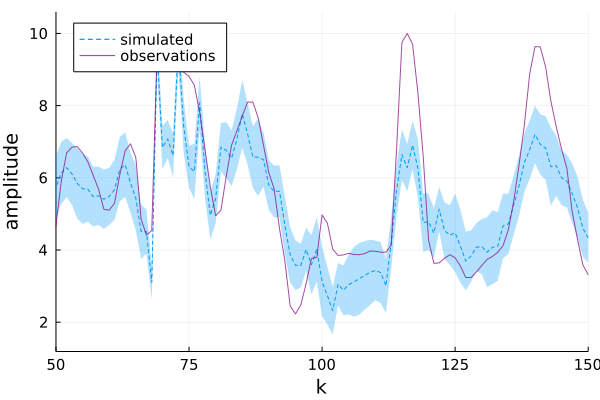

In [103]:
gr()

ps = plot(mean.(simulated_Y[delay_y+1:end]), ribbon=sqrt.(cov.(simulated_Y[delay_y+1:end])), fillalpha=0.3, linestyle=:dash, label="simulated", legend=:topleft, xlabel="k", ylabel="amplitude")
plot!(Y_test, xlims=(50, 150), label="observations", ylabelfontsize=13, xlabelfontsize=13, legendfontsize=10, markeralpha=0.3, xtickfontsize=10, ytickfontsize=10, color=:purple, width=1.0, alpha=0.7)
# savefig(ps, "../experiments/results/synthetic/simulations.tikz")

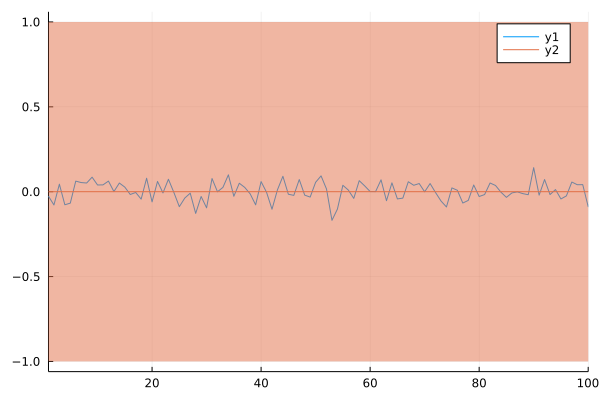

In [52]:
gr()
plot(noise_tst)
plot!(first.(mean.(simulated_error)), ribbon=first.(sqrt.(cov.(simulated_error))), xlims=(1, 100))